In [1]:
import os
import sys

# Set the parent folder (of operator_learning) as the working directory and home for imports
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(parent_dir)
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


In [ ]:
from godunov_solver.solve_class import *

nx = 50
nt = 100
dx = 0.25
dt = 0.05
bc = "GhostCell"
ic = "RiemannProblem"


In [ ]:
#import torch Dataset
import torch
from joblib import Memory
from torch.utils.data import Dataset
from tqdm import tqdm

mem = Memory(location='.cache')

def gen_grid(solver, nx, nt, dx, dt, bc):
    ic = "PiecewiseConstant"
    # Random number of steps
    n_steps = np.random.randint(1, 5)

    # Random values of steps
    steps = sorted(np.random.randint(0, nx, size=n_steps))

    # Random v for each step, between 0 and 1
    values = np.random.rand(n_steps)

    grid = Grid(nx, nt, dx, dt, ic, bc, values=values, steps=steps)
    solver.solve(grid)
    return grid.grid['h']
    

class GridDataset(Dataset):
    def __init__(self, n_samples, nx, nt, dx, dt, bc, **kwargs):
        self.n_samples = n_samples
        self.bc = bc
        solver = GodunovLWR(flux=GreenshieldsFlux(vmax=1.0, rho_max=1.0))
        self.grids = []
        for _ in tqdm(range(n_samples), desc="Generating grids"):
            self.grids.append(gen_grid(solver, nx, nt, dx, dt, bc))

    def __len__(self):
        return len(self.grids)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.grids[idx]).to(torch.float32).unsqueeze(-1)

@mem.cache
def gen_grids( n_samples, nx, nt, dx, dt):
    dataset = GridDataset(n_samples=n_samples, nx=nx, nt=nt, dx=dx, dt=dt, bc="GhostCell")
    return dataset

dataset = gen_grids(5000, nx, nt, dx, dt)


________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3860982303.gen_grids...
gen_grids(5000, 50, 100, 0.25, 0.05)


Generating grids: 100%|██████████| 5000/5000 [07:43<00:00, 10.78it/s]


______________________________________________________gen_grids - 464.5s, 7.7min


In [4]:
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset


class NonAutoregDataset(Dataset):
    """
    Dataset for non-autoregressive training (one-shot prediction).
    Returns: (full_input, targets)
    - full_input: (nt, nx, 3) - [repeated_initial_condition, time_coord, space_coord]
    - targets: (nt, nx) - ground truth at all times
    """
    def __init__(self, grids):
        """
        grids: list of numpy arrays (nt, nx) - full spatiotemporal solutions
        """
        self.grids = grids
        
    def __len__(self):
        return len(self.grids)
    
    def __getitem__(self, idx):
        grid = torch.from_numpy(self.grids[idx]).to(torch.float32)  # (nt, nx)
        nt, nx = grid.shape
        
        # Repeat initial condition for all timesteps
        input_grid = grid.clone()
        input_grid[1:, 1:-1] = -1
        
        # Create coordinate grids that tell the model what time/space to predict
        t_coords = torch.linspace(0, 1, nt)[:, None].expand(nt, nx)  # (nt, nx)
        x_coords = torch.linspace(0, 1, nx)[None, :].expand(nt, nx)  # (nt, nx)
        
        # Stack: (nt, nx, 3) where channels are [initial_density_repeated, time, space]
        full_input = torch.stack([input_grid, t_coords, x_coords], dim=-1)
        
        return full_input, grid  # Returns: (nt, nx, 3), (nt, nx)

# Create non-autoregressive dataset
non_autoreg_dataset = NonAutoregDataset(
    [grid.squeeze(-1).numpy() for grid in dataset]  # Convert to numpy
)

print(f"Dataset size: {len(non_autoreg_dataset)}")
print(f"Sample shapes: input={non_autoreg_dataset[0][0].shape}, target={non_autoreg_dataset[0][1].shape}")

Dataset size: 5000
Sample shapes: input=torch.Size([100, 50, 3]), target=torch.Size([100, 50])


In [5]:
def train_non_autoreg_epoch(
    model,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    loss_fn=nn.MSELoss(reduction="mean"),
):
    """
    Training loop for one-shot FNO prediction.
    Model predicts entire spatiotemporal solution in one forward pass.
    """
    model.train()
    running_loss = 0.0
    n_batches = 0
    
    for full_input, targets in loader:
        # full_input: (B, nt, nx, 3)
        # targets: (B, nt, nx)
        
        full_input = full_input.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        
        # FNO expects (B, C, nt, nx) for 2D, so permute
        model_input = full_input.permute(0, 3, 1, 2)  # (B, 3, nt, nx)
        
        # Forward pass - single prediction for entire grid
        pred = model(model_input)  # (B, 1, nt, nx)
        pred = pred.squeeze(1)  # (B, nt, nx)
        
        # Compute loss
        loss = loss_fn(pred, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        n_batches += 1
    
    return running_loss / max(1, n_batches)

def train_non_autoreg_model(model, dataloader, epochs, optimizer, device, 
                           lr_patience=5, early_stop_patience=10):
    """
    Train one-shot FNO for multiple epochs with learning rate scheduling and early stopping.
    """
    from tqdm import tqdm
    
    best_loss = float('inf')
    epochs_without_improvement = 0
    current_lr = optimizer.param_groups[0]['lr']
    pbar = tqdm(range(epochs), desc="Training")
    for epoch in pbar:
        loss = train_non_autoreg_epoch(model, dataloader, optimizer, device)
        
        # Check if loss improved
        if loss < best_loss:
            best_loss = loss
            epochs_without_improvement = 0
            # print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.6f} ✓ (Best)")
        else:
            epochs_without_improvement += 1
            # print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.6f} (No improvement for {epochs_without_improvement} epochs)")
        
        # Learning rate reduction
        if epochs_without_improvement == lr_patience:
            current_lr = current_lr / 10
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
            print(f"  → Learning rate reduced to {current_lr:.2e}")
        
        # Early stopping
        if epochs_without_improvement >= early_stop_patience:
            print(f"\n⚠️  Early stopping triggered after {epoch+1} epochs")
            print(f"   No improvement for {early_stop_patience} consecutive epochs")
            print(f"   Best loss: {best_loss:.6f}")
            break
        post_fix = {"curr_loss": loss, "best_loss": best_loss, "lr": current_lr}
        if epochs_without_improvement > 0:
            post_fix["no_improvement"] = epochs_without_improvement
        pbar.set_postfix(post_fix)
    
    print(f"\nTraining completed! Final best loss: {best_loss:.6f}")
    return model

In [6]:
from neuralop.models import FNO

device = torch.device("cuda" if torch.cuda.is_available() else "mps")

# Create dataloader
non_autoreg_loader = DataLoader(non_autoreg_dataset, batch_size=32, shuffle=True)

# Create FNO2d model for spatiotemporal prediction
# Input channels: 3 (density + time coord + space coord)
# Output channels: 1 (predicted density)
fno_operator = FNO(
    n_modes=(64, 16),        # modes in (time, space) dimensions
    hidden_channels=64,       # network width
    in_channels=3,           # density + time + space
    out_channels=1,          # predicted density
    n_layers=4               # number of FNO layers
).to(device)

print(f"Model parameters: {sum(p.numel() for p in fno_operator.parameters()):,}")

# Train the model
optimizer_op = torch.optim.Adam(fno_operator.parameters(), lr=1e-3)
fno_operator = train_non_autoreg_model(
    fno_operator, 
    non_autoreg_loader, 
    epochs=100, 
    optimizer=optimizer_op, 
    device=device,
    lr_patience=10,
    early_stop_patience=20
)

Model parameters: 9,488,321


Training: 100%|██████████| 100/100 [05:54<00:00,  3.55s/it, curr_loss=5.2e-5, best_loss=4.87e-5, lr=0.0001, no_improvement=10]

  → Learning rate reduced to 1.00e-04

Training completed! Final best loss: 0.000049


In [7]:
def predict_trajectory(model, input_grid, device):
    """
    Predict the full trajectory in one forward pass.
    
    Args:
        model: Trained FNO model
        input_grid: (nt, nx, 3) input with [density, time_coord, space_coord]
        device: Device to run on
        
    Returns:
        predictions: (nt, nx) - predicted trajectory
    """
    model.eval()
    
    with torch.no_grad():
        # input_grid is already (nt, nx, 3) from the dataset
        # Just add batch dimension and permute for FNO
        input_grid = input_grid.unsqueeze(0).to(device)  # (1, nt, nx, 3)
        
        # Permute for FNO: (1, 3, nt, nx)
        model_input = input_grid.permute(0, 3, 1, 2)
        
        # Predict entire trajectory in one forward pass
        pred = model(model_input)  # (1, 1, nt, nx)
        pred = pred.squeeze()  # (nt, nx)
            
    return pred

# Test prediction
test_idx = 2
test_input = non_autoreg_dataset[test_idx][0]  # Already (nt, nx, 3)
test_grid = non_autoreg_dataset[test_idx][1]   # Ground truth (nt, nx)

# Predict full trajectory in one shot
pred_traj = predict_trajectory(fno_operator, test_input, device)
pred_traj = pred_traj.cpu().numpy()  # (nt, nx)

print(f"Predicted trajectory shape: {pred_traj.shape}")
print(f"Ground truth shape: {test_grid.shape}")

Predicted trajectory shape: (100, 50)
Ground truth shape: torch.Size([100, 50])


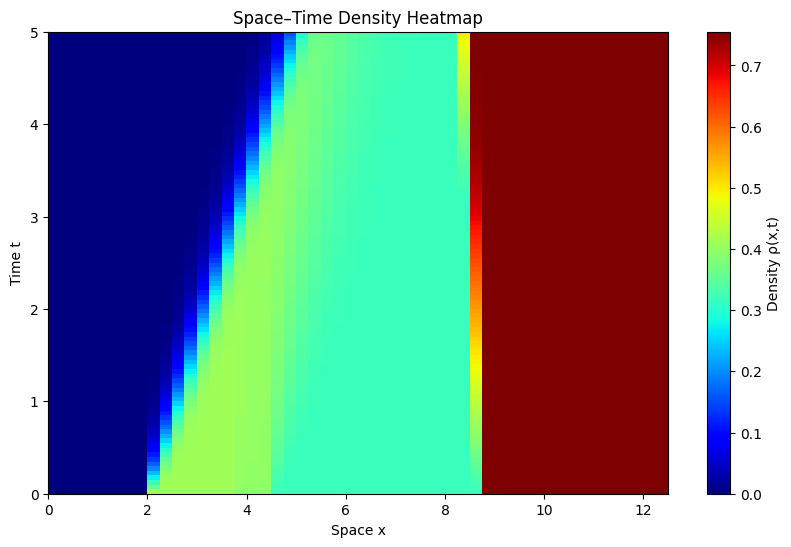

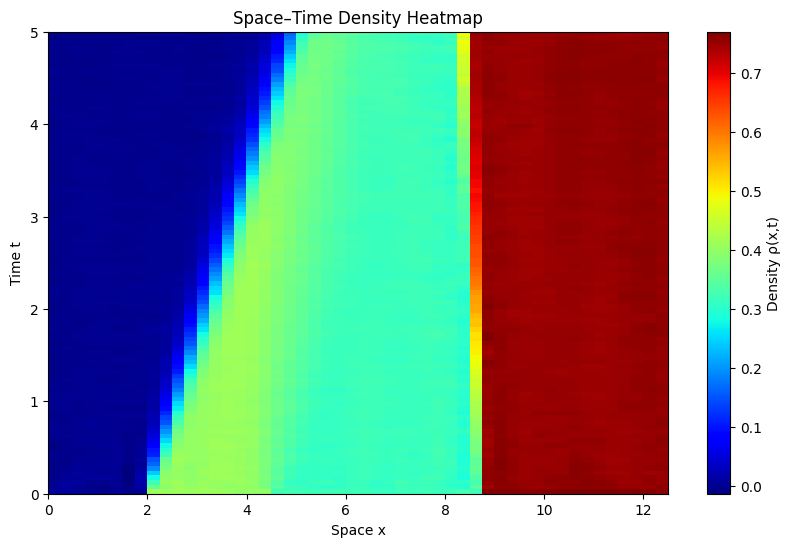

In [ ]:
from godunov_solver.plotter import plot_grid_density

plot_grid_density(test_grid.squeeze(), nx, nt, dx, dt)
plot_grid_density(pred_traj.squeeze(), nx, nt, dx, dt)